Um zunächst die einzelnen Events einer EEG Aufnahme zu clustern, müssen zunächst Signalverarbeitungsschritte durchgeführt werden, wie das Glätten, Normalisieren und Filtern des Signals. Anschließend kann ein ganzes Signal in kleine Fenster unterteilt werden, die mit einer Überlappung über die ganze Aufnahme hin erstellt werden. Somit kann sichergestellt werden, dass bei der Unterteilung des Signals in kleinere Abschnitte, ein Event in mitten des Fensters liegen kann und nicht am Rand, oder gar nur zum Teil im Fenster liegt. 
Diese Schritte können mit der vorgefertigtem Python Programm gui.py durchgeführt werden. In das Programm können EEG Daten des .eeg Formates hochgeladen werden. Das Programm erkennt automatisch Kerninformationen wie die Anzahl der genutzten Kanäle oder die Abtastrate und somit auch die Dauer der Aufzeichnung. Außerdem lassen sich die einzelnen Kanäle auch anzeigen. Im unteren rechten Bereich der Anwendung können nun die zuvor erwähnten Signalverarbeitungsschritte durchgeführt werden. Nach der Anwendung, können im linken unteren Bereich nun die Fenster erstellt werden. Hierzu ist die Überlappung und die Fenstergröße anzugeben. 
Im nächsten Schritt können die einzelnen Fenster betrachtet werden. Um nun weiter mit dem Clusterproblem fortzufahren wird mit der Download Funktion ein Array der Fenster heruntergeladen (NameDesKanals.pickle) und dem Projektverzeichnis hinzugefügt 

In [ ]:
import subprocess

subprocess.call(["python", "./gui.py"])

Um aus den enthaltenen Fenstern ein Dictionary zu ertellen, dass die Kanalbezeichung und die Nr des Fensters beinhaltet, wird die folgende Funktion verwende:

In [22]:
def create_window_dict(all_windows, raw):
    window_dict = []
    for idx, window in enumerate(all_windows):
        for id, data in enumerate(window):
            window_dict.append({'channel': raw.ch_names[idx], 'nr': id, 'data': data})
    return window_dict

### Erstellung des Dictionaries

In [ ]:
import mne
from functions import load_np_array_pickle 
all_windows = load_np_array_pickle('../../epochs_files/epochs.pickle')
raw = mne.io.read_raw_brainvision('../../files/Control1415.vhdr')
all_windows = all_windows[:-1]

window_dict = create_window_dict(all_windows, raw)
len(window_dict)


Da ein großer Teil der Fenster aus Flatlines bestehen, werden im nächsten schritt diese Fenster aus der Menge entfernt, um die folgende Rechenzeit zu verkürzen. Hierzu wird eine Funktion programmiert, die mithilfe der Standardabweichung ermittelt, welche Fenster eine Flatline beinhalten und welche eher weniger. Dafür ist es notwendig einen Grenzwert (hier: threshold) zu definieren. Um einen geeingneten Wert zu ermitteln muss die größe der Fenster beachtet werden. 

In [15]:
import numpy as np
from functions import load_np_array_pickle

def is_linear(data, threshold):
    std = np.std(data)
    if std > threshold:
        return True
    else:
        return False


def clear_flatlines(data, threshold1):
    windows = data
    
    # Entferne die Elemente, die nicht linear sind, in einer separaten Schleife
    to_delete1 = set()
    for idx1, window in enumerate(windows):
        if not is_linear(window['data'], threshold1):
            to_delete1.add(idx1)
    windows = np.delete(windows, list(to_delete1), axis=0)
    deleted_windows = [data[i] for i in to_delete1]
    
    return windows, deleted_windows

#### Filterung der Fenster aller Kanäle

In [ ]:

cleared_windows, deleted_windows = clear_flatlines(window_dict, 0.025)
len(deleted_windows)

Um zu überprüfen, welche Fenster gelöscht wurden und ob der Grenzwert für die Standardabweichung gut gewählt ist, kann die folgende Funktion aufgerufen werden. 
Diese liest die Liste der Fenster ein und gibt in 2 Sekunden abschnitten automatisch jeweils 10 Fenster aus. Damit lassen sich die gelöschten, aber auch die übrig gebliebenen Fenster einsehen um gegebenenfalls die Parameter anzupassen.

In [62]:
import matplotlib.pyplot as plt
import time

def show_plots(windows):
    start = 0
    end = 9
    fig, ax = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(10, 5))
    values = list(range(int(start), int(end) + 1))

    data_minmax = [el['data'] for el in windows]

    data_minmax = np.array([np.min(data_minmax), np.max(data_minmax)])
    ymin = np.min(data_minmax)
    ymax = np.max(data_minmax)
    print(ymin, ymax)

    while values:
        values = list(range(int(start), int(end) + 1))
        k = 0

        # Elemente entfernen, die größer als x sind
        values = [val for val in values if val <= len(windows)-1]
        print(values)
        for i in range(2):
            for j in range(5):
                if k < len(values) and k < len(windows):
                    ax[i, j].clear()
                    ax[i, j].plot(windows[values[k]]['data'])
                    ax[i, j].set_ylim(ymin, ymax)
                else:
                    ax[i, j].set_visible(False)
                k += 1

        #damit die Schleife unterbrochen wird
        if len(values) != 10:
            values = []

        start += 10
        end += 10

        plt.draw()
        plt.pause(0.1)
        time.sleep(2)
        


In [20]:
def find_cut_peaks(windows, len, marg):
    """
    Diese Funktion überprüft, ob in den Fenstern ein 'abgeschnittener' Peak vorhanden ist.
    Es wird überprüft, ob der Peak zu nah am Rand des Fensters ist.
    Die Funktion gibt zwei Listen zurück: eine Liste mit Fenstern ohne abgeschnittene Peaks und
    eine Liste mit nur den abgeschnittenen Peaks Fenstern.
    """
    window_len = len
    margin = marg  # Anzahl der Punkte, die der Peak vom Fensterrand entfernt sein muss, um nicht abgeschnitten zu sein
    good_windows = []
    cut_windows = []
    for window in windows:
        peak_idx = np.argmax(window['data'])
        if peak_idx <= margin or peak_idx >= window_len - margin:
            cut_windows.append(window)
        else:
            good_windows.append(window)
    return good_windows, cut_windows



In [ ]:


final_windows, cut_windows = find_cut_peaks(cleared_windows, 15000, 1000)
print(len(final_windows), len(cut_windows))


Startet man die linearRegression.py Datei, werden die Fenster des Fp1 Kanals (der erste Kanal) gefiltert und angezeigt. Dies kann verwendet werden, um zu analysieren, ob die gewählte Grenze der Standardabweichung ausreichend ist um unzureichende Fenster zu entfernen.

In [ ]:
import subprocess
subprocess.call(["python", "linearRegression.py", "0.02"])

#### Doppelte Signale herausfiltern 

Da die Fenster mit einer Überlappung generiert wurden, kann es dazu kommen, dass einige Signale in mehreren Fenstern in verschobener Form vorkommen. Um nun solche Fenster aus der Sammlung zu entfernen kann die folgende Funktion verwendet werden. Diese zeigt jeweils aufeinander folgende Fenster mit ihrer jeweiligen Nummer an. Anschließend können in der Konsole die Nummern angegeben werden, die aus der Sammlung von Fenstern ausgeschlossen werden sollen. 


In [12]:

def remove_neighbors(data):
    to_delete = []  # Hier werden die zu löschenden Objekte gespeichert
    epochs = data.copy()
    i = 0
    while i < len(data):
        current = data[i]
        consecutive = [current]
        for j in range(i + 1, len(data)):
            if data[j]['nr'] == current['nr'] + 1:
                current = data[j]
                consecutive.append(current)
            else:
                break
        if len(consecutive) > 1:
            # Erstelle Subplot mit der Anzahl der aufeinanderfolgenden Elemente
            raw_data = load_np_array_pickle('./epochs_files/rawdata.pickle')

            data_minmax = raw_data[:-1]

            data_minmax = np.array([np.min(data_minmax), np.max(data_minmax)])
            ymin = np.min(data_minmax)
            ymax = np.max(data_minmax)

            fig, axs = plt.subplots(1, len(consecutive), figsize=(5 * len(consecutive), 5))

            for k in range(len(consecutive)):
                axs[k].plot(consecutive[k]['data'])
                axs[k].set_title(f"nr: {consecutive[k]['nr']}")
                axs[k].set_ylim(ymin, ymax)

            plt.show()
            print(len(consecutive))
            # Auswahl und Entfernung der Fenster
            print('Geben Sie die Nr ein die entfernt werden sollen\nBei mehreren nummern, trennen Sie die Zahlen mit einem Komma')
            numbers = input()

            # Erstelle ein Array aus den Zahlen
            try:
                numbers = numbers.split(',')
            except AttributeError:
                pass

            # Entferne Leerzeichen zwischen den Zahlen
            numbers = [int(elem.strip()) for elem in numbers]

            for obj in consecutive:
                if obj['nr'] in numbers:
                    to_delete.append(obj)
        i += len(consecutive)

    for obj in to_delete:
        epochs.remove(obj)
        
    return epochs




#### Arbeiten mit annotierten Events

Viele EEG Datensätze, werden weiteren Parametern wie die Abtastrate, oder auch den verwendeten Kanälen gesichert. Bei vielen Formaten wie Brainvision werden auch Annotationen innerhalb dieser Dateien abgespeichert. Dabei wird festgehalten, wann welche Stimulation stattgefunden hat. Mittels der mne Pythonbibliothek können diese Epochen analysiert werden

Zunächst werden die Rohdaten weitesgehend gefiltert. Eine weitere Glättung und Normalisierung muss ausstehend, da durch die Glättung der Rohdaten die Abtastrate möglicherweise verändert und somit auch die zeitliche Auflösung des Signals beeinflusst  werden könnte. Dadurch können die ursprünglichen Ereignisse, die auf der ursprünglichen Abtastrate basieren, möglicherweise nicht mehr genau erkannt werden. Die im nächsten Schritt erstellten Epochen wären daher unbrauchbar. 
Stattdessen kann man die Glättung und auch Normalisierung im Nachhinein nach Erstellung der Epochen durchführen.


In [2]:
from functions import eeg_filter
import mne
from mne.preprocessing import ICA

def raw_filter(raw, ica, notch, lowpass, highpass):
    filtered_raw = raw.copy()
    if ica: 
         # Data preprocessing
        try:
            # Create ICA object
            ica = ICA(n_components=10, random_state=42)

            # Fit ICA on raw data
            ica.fit(filtered_raw)

            # Identify and remove undesirable components
            ica.exclude = [ica.labels_['eye_blink', 'muscle_activity', 'heartbeat']]

            # Apply ICA to raw data
            ica.apply(filtered_raw)

        except KeyError:
            pass
    
    if notch:
        notch_frequencies = [50, 60]

        # Anwendung des Notch-Filters
        filtered_raw = filtered_raw.notch_filter(notch_frequencies)

    if lowpass and highpass:
        # Definieren Sie die Filtergrenzen (z.B. 0,5 - 30 Hz)
        l_freq = float(lowpass)
        h_freq = float(highpass)
        # Anwenden des Butterworth-Filters
        filtered_raw.filter(l_freq, h_freq, fir_design='firwin')


    return filtered_raw


#Filter Parameter
filename = 'Control1415.vhdr'
raw = mne.io.read_raw_brainvision('../files/' + filename, preload=True)
ica = 1
notch = 1
low_pass = 8/(raw.info['sfreq']/2)
high_pass = 30/(raw.info['sfreq']/2)


filtered_raw = raw_filter(raw, ica, notch, 0.5, 30)
print(filtered_raw.ch_names)

Extracting parameters from ../files/Control1415.vhdr...
Setting channel info structure...
Reading 0 ... 810059  =      0.000 ...  1620.118 secs...


/var/folders/37/wjbnvn9s3gvb2cmxzyy0d_880000gn/T/ipykernel_9095/3422247681.py:44: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision('../files/' + filename, preload=True)
/var/folders/37/wjbnvn9s3gvb2cmxzyy0d_880000gn/T/ipykernel_9095/3422247681.py:44: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision('../files/' + filename, preload=True)
/var/folders/37/wjbnvn9s3gvb2cmxzyy0d_880000gn/T/ipykernel_9095/3422247681.py:44: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['Resp']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision('../files/' + filename, preload=True)


Fitting ICA to data using 63 channels (please be patient, this may take a while)


/var/folders/37/wjbnvn9s3gvb2cmxzyy0d_880000gn/T/ipykernel_9095/3422247681.py:14: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(filtered_raw)


Selecting by number: 10 components
Fitting ICA took 6.6s.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


['Fp1', 'Fz', 'F3', 'F7', 'Iz', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'I1', 'POz', 'I2', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF8', 'AF4', 'F2', 'FCz', 'Resp']


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


#### Events und Annotationen anzeigen

In [3]:
events, event_dict = mne.events_from_annotations(filtered_raw)
events = events[(events[:, 2] != event_dict['New Segment/']) & (events[:, 2] != event_dict['Stimulus/S255'])]

# Ausgabe der Menge an Stimuli die annotiert sind
print(event_dict)
print(events)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S255']
{'New Segment/': 99999, 'Stimulus/S  1': 1, 'Stimulus/S  2': 2, 'Stimulus/S  3': 3, 'Stimulus/S  4': 4, 'Stimulus/S  5': 5, 'Stimulus/S  6': 6, 'Stimulus/S  7': 7, 'Stimulus/S255': 255}
[[  6607      0      1]
 [  7283      0      3]
 [  7323      0      6]
 ...
 [795966      0      5]
 [797100      0      6]
 [797958      0      6]]


#### Erstellung der Epochen

In [1]:
import matplotlib.pyplot as plt

# Create epochs
tmin = -0.3
tmax = 0.7
baseline = (None, 0)
epochs = mne.Epochs(filtered_raw, 
                    events=events,
                   tmin=tmin,
                   tmax=tmax,
                   baseline=baseline,
                   preload=True) 
epochs.drop_bad()

# Extrahieren der Daten für alle Epochen
epoch_data = epochs.get_data()

# Ausgabe der Form des epoch_data-Arrays
print(epoch_data.shape)

epochs.plot()

    
plt.plot(epoch_data[0][0])
plt.show()



NameError: name 'mne' is not defined

#### Epochen Dictionary erstellen

54810


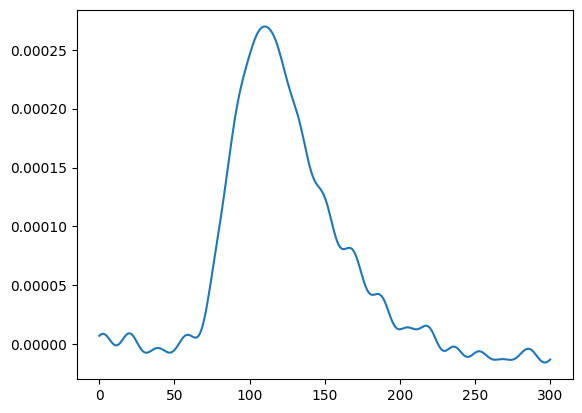

In [33]:
def create_epoch_dict(epochs, raw):
    epoch_dict= []
    amount = epochs.shape[0]
    channels = epochs.shape[1]
    
    for i in range(channels-1):
        for j in range(amount):
            
            epoch_dict.append({'channel': raw.ch_names[i], 'nr': j, 'data': epochs[j][i]})
    
    return epoch_dict
    


    
epoch_dict = create_epoch_dict(epoch_data, filtered_raw)
print(len(epoch_dict))

plt.plot(epoch_dict[0]['data'])
plt.show()


Da die Sammlung an Epochen erstellt worden ist, können diese auch Geglättet und normalisiert werden. 

In [34]:
import numpy as np


def normalize_epochs(epochs):
    # Extrahieren der Daten aus jedem Objekt in der Liste
    data_list = [obj['data'] for obj in epochs]

    # Konvertieren der Daten in ein 1D-Array
    data_array = np.concatenate(data_list)

    # Berechnen des Maximums und Minimums der Daten
    max_value = np.max(data_array)
    min_value = np.min(data_array)


    for idx, data in enumerate(epochs):
        normalized_data = []
        for value in data['data']:
            normalized_value = (value - min_value) / (max_value - min_value)
            normalized_data.append(normalized_value)
        epochs[idx]['data'] = normalized_data
    return epochs


1351 53459


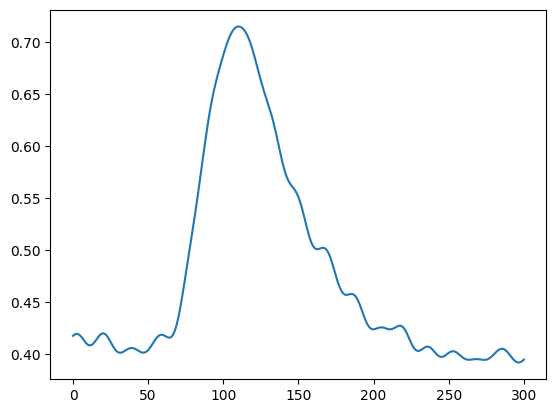

In [50]:

epoch_dict = normalize_epochs(epoch_dict)
cleared_epochs, deleted_epochs = clear_flatlines(epoch_dict, 0.025)
print(len(cleared_epochs), len(deleted_epochs))

with open("./epochs_files/flatlines.pickle", 'wb') as f:
    pickle.dump(deleted_epochs, f)


plt.plot(epoch_dict[0]['data'])
plt.show()


      


1308 43
0.14549298923290757 0.6088112428341265
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


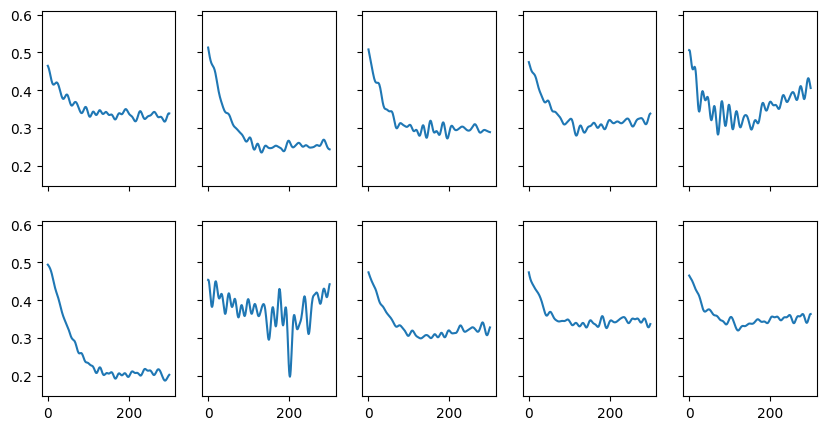

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


<Figure size 640x480 with 0 Axes>

[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


<Figure size 640x480 with 0 Axes>

[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


<Figure size 640x480 with 0 Axes>

[40, 41, 42]


<Figure size 640x480 with 0 Axes>

In [63]:
import pickle5 as pickle

final_epochs, cut_epochs = find_cut_peaks(cleared_epochs, len(cleared_epochs[0]['data']), 50/len(cleared_epochs[0]['data']))
print(len(final_epochs), len(cut_epochs))
      
      


with open("./epochs_files/epoch_dict.pickle", 'wb') as f:
    pickle.dump(final_epochs, f)
      

show_plots(cut_epochs)

#### Neue Kreuzkorrelationsfunktion

In [170]:
import numpy as np
import scipy as sp
import time
def create_corrMatrix(data_dict):
    start = time.perf_counter()
    corr_len = len(data_dict)
    matrix = np.zeros((corr_len, corr_len))
    status_percentage = int(corr_len / 100) if corr_len > 100 else 1
    
    for i in range(corr_len):
        if i % status_percentage == 0:
            progress = int((i / corr_len) * 100)
            print(f"\r Loading:  {progress}%", end='', flush=True)
        for j in range(i, corr_len):
            sig1 = data_dict[i]['data']
            sig2 = data_dict[j]['data']
            
            # Zentrieren der Signale
            nsig1 = sig1 - np.mean(sig1)
            nsig2 = sig2 - np.mean(sig2)
        
            corr = sp.signal.correlate(nsig1, nsig2, mode='same', method='fft')
            corr /= (len(sig2) * np.std(sig1) * np.std(sig2))  # Normalization
            max_corr = find_highest_peak(corr)
            matrix[i,j] = max_corr[1]
            matrix[j,i] = max_corr[1]
    end = time.perf_counter()
    print('\nAufgebrachte Zeit:  {:.2f} s'.format(end-start, 2))
    
    # Saving the objects:
    with open('correlation_matrix', 'w') as f: 
        pickle.dump(matrix, f)
    return matrix


def find_highest_peak(data):
    data_array = np.array(data)
    highest_peak_index = np.argmax(data_array)
    highest_peak_value = data_array[highest_peak_index]
    return highest_peak_index,highest_peak_value


In [171]:
matr = create_corrMatrix(final_epochs)

 Loading:  99%
Aufgebrachte Zeit:  268.33 s


In [155]:
matr2 =  load_np_array_pickle('./epochs_files/correlation_compare.pickle')

In [162]:
print(matr2.shape)

(1745, 1745)


In [174]:
if np.array_equal(matr2, matr):
    print("Arrays are equal")
else:
    diff_idx = np.where(matr2 != matr)
    print("Arrays differ at index", diff_idx)

Arrays are equal


Letzlich kann begonnen werden, die Korrelationsmatrix zu bestimmen. Diese Matrix der Dimension MxM, wobei M für die Menge der Fenster steht, gibt dabei den Korrelationskoeffizienten der Fenster zueinander an. 

Die Funktion 'correlate_matrix' nimmt als Eingabe ein Fenster (window) und ein Array aus Fenstern (epochs). Für jedes Fenster in epochs wird der folgende Prozess durchgeführt:

1. Überprüfung, ob das Längen des Fensters und des aktuellen Epochs gleich sind, da gerade das letzte Fenster nicht der gleichen Länge entsprechen muss.
2. Wenn die Längen gleich sind, wird das Fenster mit shift_data verschoben.
3. Anschließend wird mit find_highest_peak das höchste Peak des Korrelationsverlaufs gefunden.
4. Der Wert des höchsten Peaks wird in ein Array namens correlation_data gespeichert.

Die Funktion 'shift_data' verschiebt das Fenster um 'step' nach rechts. Anschließend wird die Korrelation des verschobenen und des statischen Fensters. Dadurch wird sichergestellt, dass die maximale Korrelation berechnet wird, wenn beide Events (Ausschläge im Fenster) übereinander liegen. 
Folglich erhaltet man ein Verlauf der Korrelation über die Verschiebung. Der Peak dieses Verlaufs gibt dabei die maximale übereinstimmung an, die für die Korrelationsmatrix verwendet wird. 
Dieser Peak wird mit der 'find_highest_peak' Funktion ermittelt

In [17]:
def shift_data(data, data2, step):
    data_arr = np.array(data)
    real_data = data_arr
    data_arr2 = np.array(data2)
    t = 0
    correlation_results = []  # Array zum Speichern der Korrelationsergebnisse erstellen

    while t == 0:


        copy_data = np.copy(data_arr)
        copy_data[step:] = data_arr[:-step]  # Verschiebe Daten um step nach rechts
        copy_data[:step] = data_arr[-step:]  # füge die ersten step Daten an das Ende an
        data_arr = copy_data

        correlation = np.corrcoef(data_arr, data_arr2)[0, 1]  # Calculate cross correlation
        correlation_results.append(correlation)  # add the correlation to the results array

        if np.array_equal(data_arr, real_data):
            t = 1

    return correlation_results


def find_highest_peak(data):
    data_array = np.array(data)
    highest_peak_index = np.argmax(data_array)
    highest_peak_value = data_array[highest_peak_index]
    return highest_peak_index,highest_peak_value



def correlate_matrix(window, window_dict):
    correlation_data = []
    for idx, data in enumerate(window_dict):
        if len(window) == len(data['data']):
            # shift the window
            s_data = shift_data(window, data['data'], 1)
            # find peak info
            peak_index, peak_value = find_highest_peak(s_data)
            correlation_data.append(peak_value)

    return correlation_data

Nachdem die Korrelationsmatrix berechnet wurde, können darauf unterschiedliche Clusteralgorithmen angewendet werden. 
Verwendet werden:
1. kmeans
2. dbscan
3. hierachical clustering

#### Kmeans 

Der k-Means-Algorithmus ist ein bekanntes Verfahren in der Datenanalyse, bei dem eine gegebene Datenmenge in k Cluster unterteilt wird. Dabei werden die Datenpunkte so gruppiert, dass die Daten innerhalb eines Clusters möglichst ähnlich sind und die Daten zwischen verschiedenen Clustern möglichst unähnlich sind.

Der k-Means-Algorithmus eignet sich gut für die Clusteranalyse von Korrelationsmatrizen, da Korrelationsmatrizen Messwerte enthalten, die das lineare Zusammenhangsmaß zwischen verschiedenen Variablen beschreiben. Diese Messwerte können als Merkmale verwendet werden, um Datenpunkte in ähnliche Gruppen zu unterteilen.

In dem gegebenen Code wird zunächst eine Abstandsmatrix berechnet, die aus den Korrelationswerten berechnet wird. Hierfür wird jeder Wert in der Korrelationsmatrix mit 1 subtrahiert. Die Abstandsmatrix beschreibt nun den Abstand zwischen den verschiedenen Merkmalen und kann verwendet werden, um die Datenpunkte zu clustern.

Im nächsten Schritt wird die optimale Anzahl an Clustern mithilfe des sogenannten Elbow-Methods bestimmt. Das Elbow-Method basiert auf der Tatsache, dass die Summe der quadratischen Abstände zwischen den Datenpunkten und dem Zentroiden eines Clusters abnimmt, wenn die Anzahl an Clustern zunimmt. Bei einer bestimmten Anzahl an Clustern wird ein Elbow erreicht, bei dem die Summe der quadratischen Abstände nur noch geringfügig abnimmt. Diese Anzahl an Clustern wird als optimal angesehen.

Mit Hilfe des Elbow-Methods kann in dem gegebenen Code die optimale Anzahl an Clustern aus einem Bereich von 1 bis 15 ausgewählt werden. Anschließend wird der k-Means-Algorithmus auf die Abstandsmatrix angewendet und die Datenpunkte werden in die gewählte Anzahl an Clustern unterteilt. Die Cluster-Zuordnungen werden schließlich gespeichert.



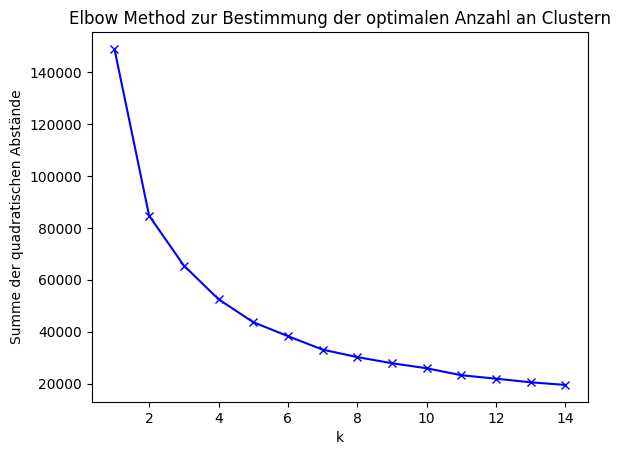

Wähle die optimale Anzahl an Clustern aus dem Elbow-Plot aus: 3
Cluster-Zuordnungen: 
 [0 0 0 ... 2 1 0]


In [58]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")
from functions import load_np_array_pickle
import pickle5 as pickle

def kmeans_cluster():
    # Korrelationsmatrix
    cross_correlations = load_np_array_pickle('./epochs_files/correlation_compare.pickle')
    distance_matrix = cross_correlations

    # Berechne optimale Anzahl an Clustern mithilfe des Elbow-Methods
    sum_of_squared_distances = []
    K = range(1, 15)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(distance_matrix)
        sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Summe der quadratischen Abstände')
    plt.title('Elbow Method zur Bestimmung der optimalen Anzahl an Clustern')
    plt.show()

    # Anwenden des k-Means-Algorithmus auf die Korrelationsmatrix
    optimal_number_of_clusters = int(input("Wähle die optimale Anzahl an Clustern aus dem Elbow-Plot aus: "))
    kmeans = KMeans(n_clusters=optimal_number_of_clusters)
    kmeans.fit(distance_matrix)
    labels = kmeans.labels_
    print("Cluster-Zuordnungen: \n", labels)
    with open("./cluster_data/kmeans.pickle", 'wb') as f:
        pickle.dump(labels, f)
        
if __name__ == "__main__":
    kmeans_cluster()

#### DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) ist eine Clustering-Methode, die sich auf den Abstand von Datenpunkten konzentriert, um Clusters zu bilden. Die beiden wichtigsten Parameter, die bei DBSCAN verwendet werden, sind Epsilon (eps) und min_samples.

Epsilon (eps) ist ein Radius, der angibt, wie weit Datenpunkte voneinander entfernt sein dürfen, um noch Teil des gleichen Clusters zu sein. Je größer der Radius, desto größer werden die Clusters und desto mehr Datenpunkte werden zusammen in einem Cluster klassifiziert.

Min_samples ist die minimale Anzahl an Datenpunkten, die erforderlich ist, um ein Cluster zu bilden. Wenn weniger Datenpunkte innerhalb des Radius (eps) vorhanden sind, wird kein Cluster gebildet.

In diesem Code wird der beste Wert für Epsilon und min_samples selbst ermittelt, indem für jeden Wert von Epsilon (eps) und min_samples ein DBSCAN-Modell erstellt wird und das Modell mit dem höchsten Silhouette Score verwendet wird.

Der Silhouette Score ist ein Metrik, die die Ähnlichkeit eines Datenpunkts zu seinem eigenen Cluster im Vergleich zu anderen Clustern misst. Ein hoher Silhouette Score bedeutet, dass die Datenpunkte in einem Cluster gut zusammenpassen und dass die Cluster gut voneinander getrennt sind.

Im Vergleich zu KMeans ist DBSCAN eine robustere Methode, die in der Lage ist, Cluster mit unregelmäßigen Formen und unterschiedlichen Größen zu erkennen. Es ist somit möglich, unstrukturierten Daten, bei denen es keine vordefinierte Anzahl an Clustern gibt, diesen Algorithmus anzuwenden Daher kann DBSCAN in diesem Fall für das Clustering einer großen Korrelationsmatrix besser geeignet sein als KMeans.

In [176]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import sys
sys.path.insert(0, "..")
from functions import load_np_array_pickle
import pickle5 as pickle


def dbscan_cluster():
    # Abstandsmatrix
    cross_correlations = load_np_array_pickle('./epochs_files/correlation_compare.pickle')
    dist_matrix = cross_correlations
    np.fill_diagonal(dist_matrix, 0)
    best_score = -1
    best_eps = 0
    best_min_samples = 0

    for eps in np.arange(0.1, 1.0, 0.1):
        print(eps)
        for min_samples in range(2, dist_matrix.shape[0]):
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
            labels = dbscan.fit_predict(dist_matrix)

            # Check if number of clusters is greater than 1
            if len(set(labels)) > 1:
                score = silhouette_score(dist_matrix, labels, metric='precomputed')
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples

    # Re-run DBSCAN with best parameters
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric='precomputed')
    labels = dbscan.fit_predict(dist_matrix)
    print("Optimal DBSCAN parameters: eps = {}, min_samples = {}".format(best_eps, best_min_samples))
    print("Cluster labels: \n", labels)
    with open("./cluster_data/dbscan.pickle", 'wb') as f:
        pickle.dump(labels, f)

if __name__ == "__main__":
    dbscan_cluster()


0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
Optimal DBSCAN parameters: eps = 0.1, min_samples = 3
Cluster labels: 
 [-1  0 -1 ...  0  0 -1]


#### Hierachical

Der hierarchische Algorithmus ist ein Ansatz für die Clusteranalyse, bei der die Datenpunkte in einer Hierarchie von Clustergruppen organisiert werden. Diese Methode eignet sich besonders gut für die Analyse von Korrelationsmatrizen, da sie die Beziehungen zwischen den Datenpunkten gut darstellen kann.
Das darauffolgende Dendrogramm visualisiert die Hierarchie von Clustern, indem es eine graphische Darstellung der Verknüpfungen zwischen den einzelnen Datenelementen bereitstellt. Dies ermöglicht es dem Benutzer, die Struktur der Cluster zu überprüfen und zu beurteilen, wie gut sie die Datenelemente organisieren.



Um die optimale Anzahl an Cluster zu bestimmen, wird die 2. Ableitung der Abstände berechnet und angezeigt. Die optimale Anzahl an Cluster ist derjenige Wert, bei dem ein Maximum der 2. Ableitung erreicht wird. Dieser Ansatz basiert auf dem Prinzip, dass bei einer zu großen Anzahl an Cluster die Abstände zwischen den Clustergruppen zu klein werden und bei einer zu geringen Anzahl an Cluster die Clustergruppen zu heterogen werden. Das Maximum der 2. Ableitung markiert den Punkt, bei dem die Abstände noch ausreichend groß sind und die Clustergruppen noch ausreichend homogen.
Im zweiten Plot zeigt der obere Verlauf die letzten 10 Werte des Z-Arrays, welches die Hierarchie des Clusterns darstellt. Diese 10 Werte entsprechen den Abständen zwischen den Clusterzusammenführungen beim hierarchischen Algorithmus. Indem man den Verlauf dieser Abstände über die Anzahl der Zusammenführungen hinweg betrachtet, kann man eine Vorstellung davon bekommen, wann die Clusternzahl maximal war und wann sie begonnen hat zu reduzieren.
Der untere Verlauf stellt dabei die zweite Ableitung dar. 

Die Methode 'ward' wird verwendet, um die Distanzen zwischen den Clusterzusammenführungen zu berechnen. Die Methode 'ward' ist eine Variante des "ward linkage" Algorithmus und ist für korrelierte Daten gut geeignet, da sie versucht, die Varianz innerhalb jedes Clusters so gering wie möglich zu halten.

Das Kriterium 'maxclust' wird verwendet, um die optimale Anzahl der Cluster zu bestimmen. Mit 'maxclust' wird festgelegt, dass die Clusternzahl so hoch wie möglich sein soll, solange die Abstände zwischen den Clusterzusammenführungen noch hoch genug sind. Hierbei wird die maximale Anzahl an Cluster bestimmt, bei der die Abstände noch hoch genug sind, um sie als separate Cluster zu betrachten. Diese Methode eignet sich für die Analyse von Korrelationsmatrizen, da sie sicherstellt, dass ähnliche Datenpunkte in einem Cluster zusammengefasst werden.

Zusammenfassend bietet sich der hierarchische Algorithmus für Korrelationsmatrizen an, weil er eine Möglichkeit bietet, eine Hierarchie von Cluster-Schätzungen aufzubauen, die in der Regel eine bessere Vorstellung von der Struktur der Daten gibt als ein nicht-hierarchisches Clustering. Der hier vorgestellte Code implementiert den Hierarchischen Algorithmus und berechnet die optimale Anzahl an Clustern auf der Basis der mathematischen Analyse des Dendrogramms und der Beschleunigung. Am Ende berechnet der Algorithmus die Cluster-Zuordnung für jeden Datenpunkt und speichert sie in einer Datei.

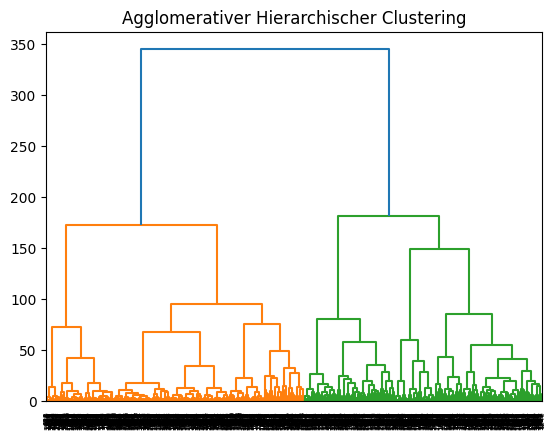

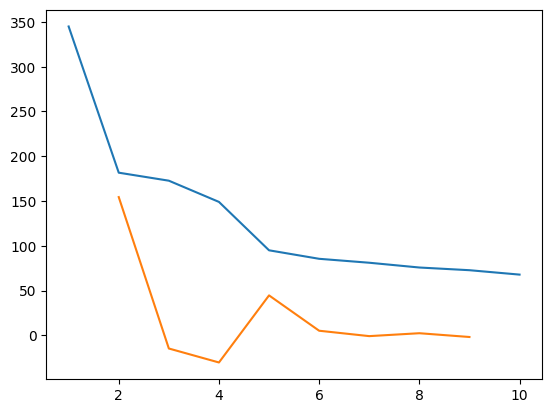

Optimale Anzahl an Clustern:  2
Cluster-Zuordnung für jeden Datenpunkt:  
 [1 1 1 ... 2 2 1]


In [60]:
import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")
from functions import load_np_array_pickle
import pickle5 as pickle


def hierachical_cluster():
    # Abstandsmatrix
    cross_correlations = load_np_array_pickle('./epochs_files/corrMat.pickle')
    distance_matrix = 1 - cross_correlations
    # Berechne den Hierarchischen Clustering
    Z = sch.linkage(distance_matrix, method='ward')

    # Plotte den Dendrogramm
    plt.title("Agglomerativer Hierarchischer Clustering")
    sch.dendrogram(Z, labels=np.arange(len(distance_matrix)))
    plt.show()

    # Bestimme die ideale Anzahl an Clustern
    last = Z[-10:, 2]
    last_rev = last[::-1]
    idxs = np.arange(1, len(last) + 1)
    plt.plot(idxs, last_rev)

    acceleration = np.diff(last, 2)  # 2nd Derivative of the distances
    acceleration_rev = acceleration[::-1]
    plt.plot(idxs[:-2] + 1, acceleration_rev)
    plt.show()
    k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
    print("Optimale Anzahl an Clustern: ", k)

    # Hierarchischer Cluster Algorithmus
    linked = linkage(distance_matrix, method='ward')
    # Clusterberechnung
    clusters = fcluster(linked, k, criterion='maxclust')
    print("Cluster-Zuordnung für jeden Datenpunkt:  \n", clusters)
    with open("./cluster_data/hierachical.pickle", 'wb') as f:
         pickle.dump(clusters, f)

if __name__ == "__main__":
    hierachical_cluster()

#### Blockmodellierung

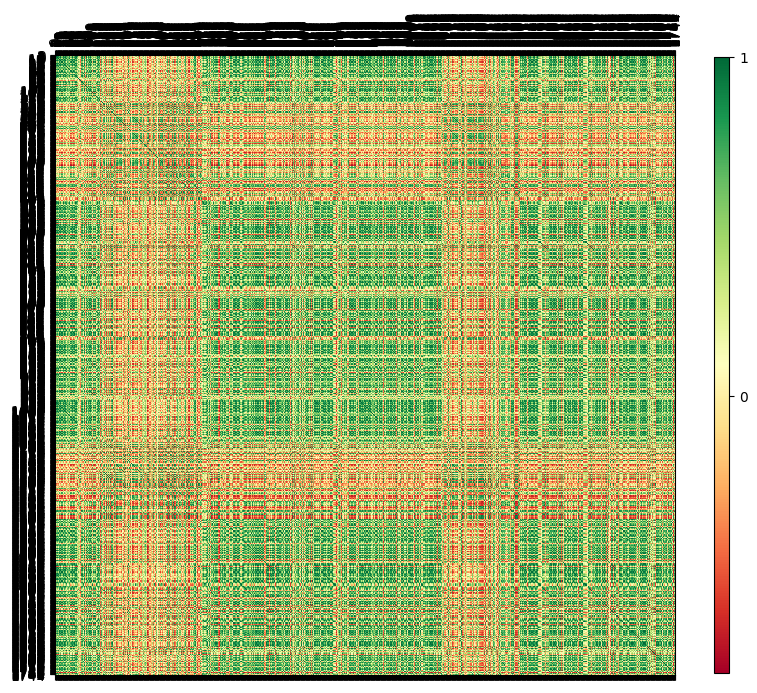

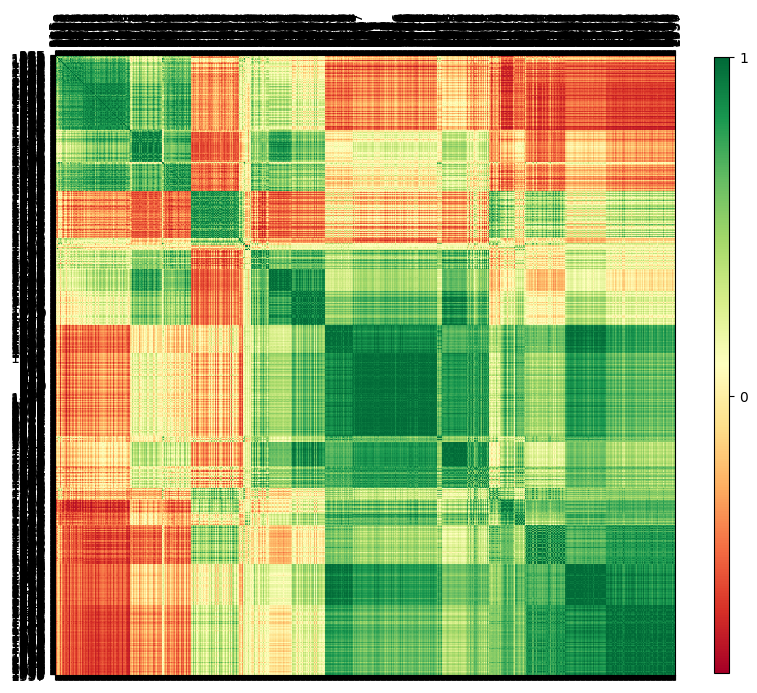

In [59]:
import matplotlib.pyplot as plt
from functions import load_np_array_pickle
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch


def plot_corr(df, size=10):
    """
    Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot 
    """

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()

    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)

    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)
    plt.show()

cross_correlations = load_np_array_pickle('./epochs_files/corrMat.pickle')
df = pd.DataFrame(cross_correlations)
plot_corr(df, size=10)


cluster_th = 10

X = df.corr().values
d = sch.distance.pdist(X)
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')

columns = [df.columns.tolist()[i] for i in list(np.argsort(ind))]
df = df.reindex(columns, axis=1)

unique, counts = np.unique(ind, return_counts=True)
counts = dict(zip(unique, counts))

i = 0
j = 0
columns = []
for cluster_l1 in set(sorted(ind)):
    j += counts[cluster_l1]
    sub = df[df.columns.values[i:j]]
    if counts[cluster_l1]>cluster_th:
        X = sub.corr().values
        d = sch.distance.pdist(X)
        L = sch.linkage(d, method='ward')
        ind = sch.fcluster(L, 0.5*d.max(), 'maxclust')
        col = [sub.columns.tolist()[i] for i in list((np.argsort(ind)))]
        sub = sub.reindex(col, axis=1)
    cols = sub.columns.tolist()
    columns.extend(cols)
    i = j
df = df.reindex(columns, axis=1)

plot_corr(df, 10)
plt.show()

Nachdem die Cluster gebildet wurden können diese mit der 'cluster_results.py' Datei untersucht werden. Dieses Script verlangt zunächst eine Eingabe, die den zu untersuchenden Cluster-Algorithmus festlegt und öffnet anschließend eine Benutzeroberfläche. In einer Liste werden die erstellten Cluster mit der Anzahl an Elementen angezeigt. Mit einem Druck auf eines der Cluster kann man in einer nächsten Ansicht alle Fenster des Clusters einsehen um die Cluster Merkmale zu ermitteln 